In [1]:
# === PASO 1: Configuración ===
# Elija el paciente y el registro que sabe que existe de la lista de PhysioNet
subject_id = 2
run_id = 16 # Por ejemplo, el registro 16 del paciente 2

In [2]:
# === PASO 2: Carga e Inspección ===
import mne
import os
import urllib.request

filename = f'chb{subject_id:02d}_{run_id:02d}.edf'
if not os.path.exists(filename):
    print(f"Descargando '{filename}'...")
    url = f'https://physionet.org/files/chbmit/1.0.0/chb{subject_id:02d}/{filename}'
    urllib.request.urlretrieve(url, filename)
else:
    print(f"El archivo '{filename}' ya existe.")

raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)
raw.pick_types(eeg=True)

print("\n--- Información del Archivo ---")
print(raw.info)
print("\n--- Nombres de los Canales ---")
print(raw.ch_names)

Descargando 'chb02_16.edf'...


C:\Users\artur\AppData\Local\Temp\ipykernel_18776\811491509.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).

--- Información del Archivo ---
<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2074-07-25 09:31:46 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: Surrogate>
>

--- Nombres de los Canales ---
['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']


In [3]:
# === PASO 3: Preprocesamiento (Filtrado) ===
raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0, verbose=False)
print("Datos filtrados y listos en la variable 'raw_filtered'.")

Datos filtrados y listos en la variable 'raw_filtered'.


In [4]:
# === PASO 4: Entrenamiento y Diagnóstico de ICA ===
from mne.preprocessing import ICA

print("Entrenando ICA (puede tardar unos minutos)...")
ica = ICA(n_components=20, max_iter='auto', random_state=97) # Usamos 20 componentes para más detalle
ica.fit(raw_filtered, verbose=False)

print("\n--- ¡ACCIÓN REQUERIDA! ---")
print("Inspeccione el siguiente gráfico y anote los números de los componentes de artefactos.")
ica.plot_sources(raw_filtered)

Entrenando ICA (puede tardar unos minutos)...

--- ¡ACCIÓN REQUERIDA! ---
Inspeccione el siguiente gráfico y anote los números de los componentes de artefactos.
Creating RawArray with float64 data, n_channels=20, n_times=245504
    Range : 0 ... 245503 =      0.000 ...   958.996 secs
Ready.
Using qt as 2D backend.


In [5]:
# === PASO 5: Limpieza (basada en su decisión) y Análisis Final ===
import numpy as np
import antropy as ant
import matplotlib.pyplot as plt

# --- ¡SU DECISIÓN AQUÍ! ---
# Basado en el gráfico anterior, edite la siguiente línea con los números de los artefactos.
components_a_excluir = [0, 1, 2] # <--- EDITE ESTA LÍNEA

# --- Limpieza y Análisis ---
print(f"Excluyendo componentes {components_a_excluir}...")
raw_cleaned = ica.apply(raw_filtered.copy(), exclude=components_a_excluir, verbose=False)
print("Datos limpios y listos.")

# (Aquí podríamos añadir el código de la entropía, homología, etc.)
# Por ahora, simplemente visualicemos el resultado de la limpieza.
print("\nMostrando datos limpios...")
raw_cleaned.plot(scalings='auto', title=f'Datos Limpios - Paciente {subject_id} Registro {run_id}')

Excluyendo componentes [0, 1, 2]...
Datos limpios y listos.

Mostrando datos limpios...


Channels marked as bad:
none


In [6]:
%pip install antropy

Note: you may need to restart the kernel to use updated packages.


Iniciando análisis de entropía para el paciente actual...

Generando mapa topográfico de la entropía...


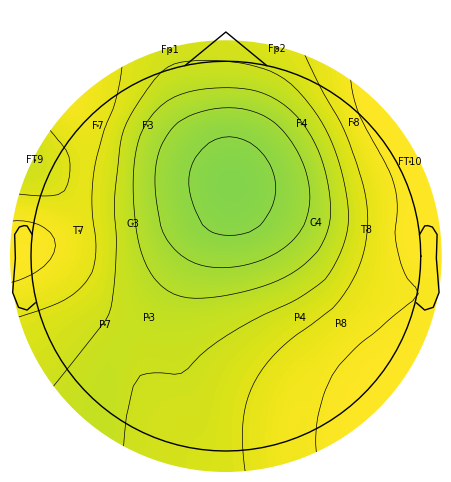

C:\Users\artur\AppData\Local\Temp\ipykernel_18776\3895110715.py:47: UserWarning: Adding colorbar to a different Figure <Figure size 600x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax1)


<Figure size 640x480 with 0 Axes>


Generando gráfico de barras de la entropía...


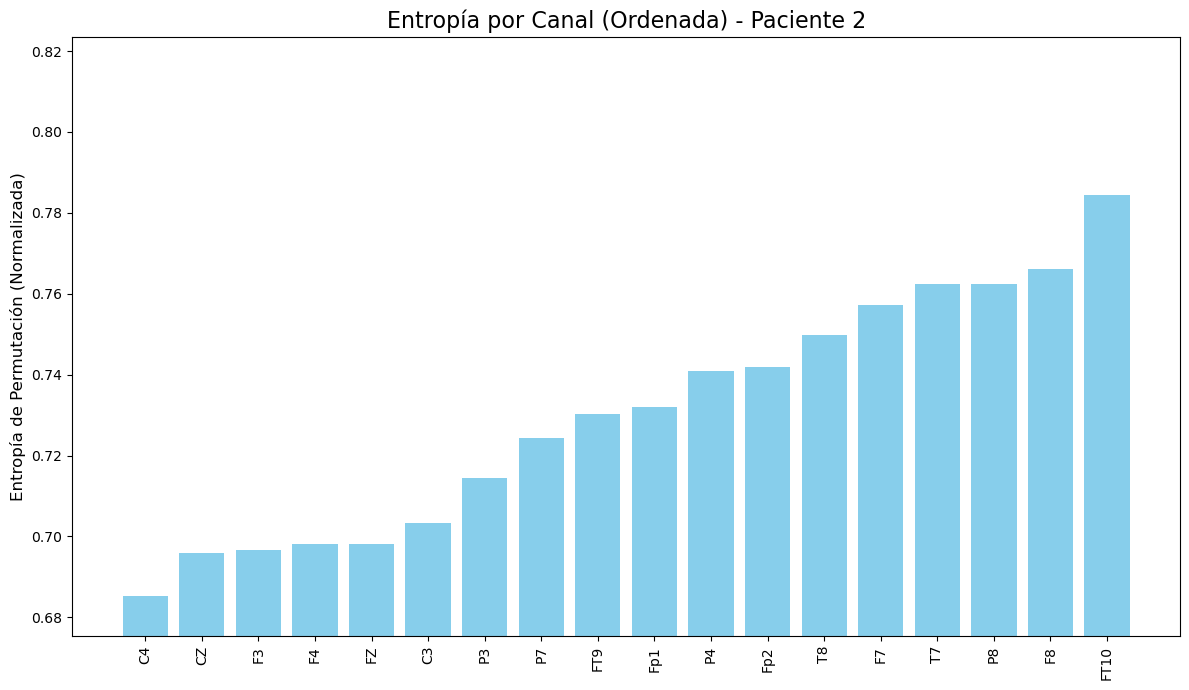

In [7]:
# === Análisis de Entropía para el Paciente Actual ===

import matplotlib.pyplot as plt
import numpy as np
import antropy as ant
import mne

print("Iniciando análisis de entropía para el paciente actual...")

# --- Paso 1: Calcular la entropía para cada canal ---
datos_eeg = raw_cleaned.get_data(units='V')
nombres_canales = raw_cleaned.ch_names
entropias = {name: ant.perm_entropy(datos_eeg[i], normalize=True) for i, name in enumerate(nombres_canales)}

# --- Paso 2: Preparar datos para los gráficos (promediar y corregir nombres) ---
entropia_promediada = {}
conteo_canales = {}
for nombre_bipolar, valor_entropia in entropias.items():
    nombre_principal = nombre_bipolar.split('-')[0]
    if nombre_principal not in entropia_promediada:
        entropia_promediada[nombre_principal] = 0
        conteo_canales[nombre_principal] = 0
    entropia_promediada[nombre_principal] += valor_entropia
    conteo_canales[nombre_principal] += 1
for nombre, suma in entropia_promediada.items():
    entropia_promediada[nombre] = suma / conteo_canales[nombre]

nombres_originales = list(entropia_promediada.keys())
valores_originales = list(entropia_promediada.values())
nombres_corregidos = [name.replace('FP', 'Fp') for name in nombres_originales]

# --- Paso 3: Generar Mapa Topográfico ---
montage = mne.channels.make_standard_montage('standard_1020')
canales_para_plot = []
valores_para_plot = []
for i, name in enumerate(nombres_corregidos):
    if name in montage.ch_names:
        canales_para_plot.append(name)
        valores_para_plot.append(valores_originales[i])

info = mne.create_info(ch_names=canales_para_plot, sfreq=raw_cleaned.info['sfreq'], ch_types='eeg')
info.set_montage(montage)

print("\nGenerando mapa topográfico de la entropía...")
fig1, ax1 = plt.subplots(figsize=(6, 6))
im, cn = mne.viz.plot_topomap(data=valores_para_plot, pos=info, axes=ax1, show=True, cmap='viridis', names=canales_para_plot)
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Entropía de Permutación (Normalizada)')
ax1.set_title('Mapa de Entropía - Paciente 2', fontsize=16)
plt.show()

# --- Paso 4: Generar Gráfico de Barras ---
print("\nGenerando gráfico de barras de la entropía...")
sorted_items = sorted(entropia_promediada.items(), key=lambda item: item[1])
sorted_channels = [item[0].replace('FP','Fp') for item in sorted_items] # Corregimos nombres aquí también
sorted_entropies = [item[1] for item in sorted_items]

fig2, ax2 = plt.subplots(figsize=(12, 7))
ax2.bar(sorted_channels, sorted_entropies, color='skyblue')
ax2.set_ylabel('Entropía de Permutación (Normalizada)', fontsize=12)
ax2.set_title('Entropía por Canal (Ordenada) - Paciente 2', fontsize=16)
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylim(bottom=np.min(sorted_entropies) - 0.01) # Límite Y dinámico
plt.tight_layout()
plt.show()

Calculando la matriz de correlación entre todos los canales para el Paciente 2...
Matriz de correlación calculada.
Dimensiones de la matriz: (23, 23)

Mostrando la matriz de correlación como un mapa de calor...


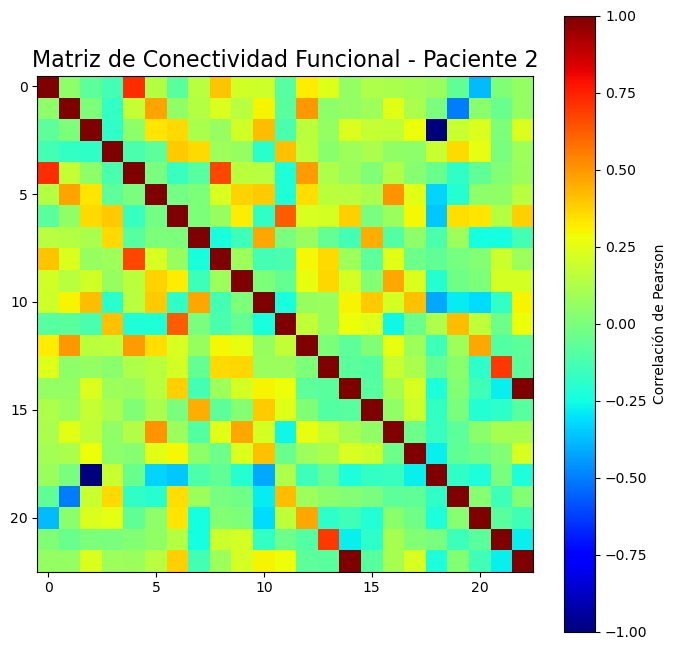

In [8]:
# === Bloque de Construcción de Red: Matriz de Correlación (Paciente 2) ===
import numpy as np
import matplotlib.pyplot as plt

print("Calculando la matriz de correlación entre todos los canales para el Paciente 2...")

# Extraemos los datos limpios del Paciente 2
# La transpuesta (.T) es para ordenar los datos correctamente para el cálculo
datos_eeg = raw_cleaned.get_data().T

# Calculamos la matriz de correlación
matriz_correlacion = np.corrcoef(datos_eeg, rowvar=False)

print("Matriz de correlación calculada.")
print("Dimensiones de la matriz:", matriz_correlacion.shape)

# --- Visualización de la Matriz ---
print("\nMostrando la matriz de correlación como un mapa de calor...")
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(matriz_correlacion, cmap='jet', interpolation='nearest')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Correlación de Pearson')
ax.set_title('Matriz de Conectividad Funcional - Paciente 2', fontsize=16)

plt.show()

In [9]:
%pip install ripser persim

Note: you may need to restart the kernel to use updated packages.


Calculando la homología persistente para la red del Paciente 2...

Análisis completado. Se encontraron 16 bucles (Betti 1) a lo largo de la filtración.

Mostrando el diagrama de persistencia...


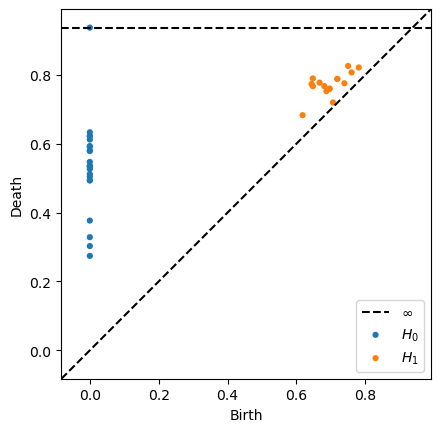

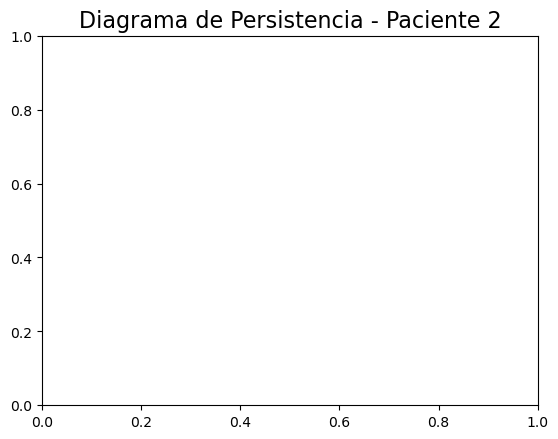

In [10]:
# === Análisis de Homología (Paciente 2) ===

import ripser
import persim
import numpy as np
import matplotlib.pyplot as plt

# La 'matriz_correlacion' del Paciente 2 ya está en memoria
# La convertimos a una matriz de distancia para el algoritmo
matriz_distancia = 1 - np.abs(matriz_correlacion)

print("Calculando la homología persistente para la red del Paciente 2...")
# Calculamos los diagramas de persistencia para dimensiones 0 (componentes) y 1 (bucles)
diagramas = ripser.ripser(matriz_distancia, maxdim=1, distance_matrix=True)['dgms']

persistencia_h1 = diagramas[1]
print(f"\nAnálisis completado. Se encontraron {len(persistencia_h1)} bucles (Betti 1) a lo largo de la filtración.")

# --- Visualización del Diagrama de Persistencia ---
print("\nMostrando el diagrama de persistencia...")
persim.plot_diagrams(diagramas, show=True)
plt.title('Diagrama de Persistencia - Paciente 2', fontsize=16)
plt.show()

Iniciando cálculo de curvatura para el Paciente 2...
Calculando curvatura para cada conexión...
Cálculo de curvatura finalizado.

Generando el gráfico de la red coloreado por curvatura...


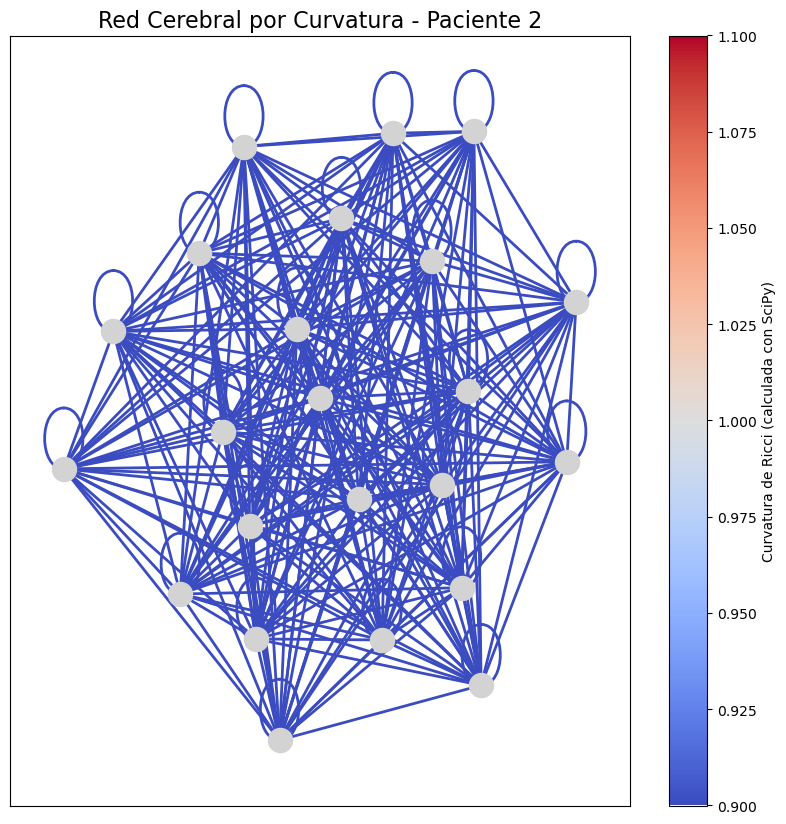

In [11]:
# === Análisis de Curvatura (Paciente 2) ===

import networkx as nx
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import numpy as np

print("Iniciando cálculo de curvatura para el Paciente 2...")

# --- Función de Curvatura ---
def calcular_curvatura(G):
    print("Calculando curvatura para cada conexión...")
    for u, v in G.edges():
        d_u, d_v = G.degree(u), G.degree(v)
        if d_u == 0 or d_v == 0: continue
        p_u, p_v = np.ones(d_u)/d_u, np.ones(d_v)/d_v
        dist = wasserstein_distance(np.arange(d_u), np.arange(d_v), p_u, p_v)
        G[u][v]['ricciCurvature'] = 1 - dist
    return G

# --- Aplicación y Visualización ---
# 'matriz_correlacion' del Paciente 2 ya está en memoria
G = nx.from_numpy_array(np.abs(np.nan_to_num(matriz_correlacion)))

G_con_curvatura = calcular_curvatura(G.copy())
print("Cálculo de curvatura finalizado.")

print("\nGenerando el gráfico de la red coloreado por curvatura...")
curvaturas = [d['ricciCurvature'] for u, v, d in G_con_curvatura.edges(data=True)]
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(G_con_curvatura, seed=42)
edges = nx.draw_networkx_edges(G_con_curvatura, pos, edge_color=curvaturas, edge_cmap=plt.cm.coolwarm, width=2)
nodes = nx.draw_networkx_nodes(G_con_curvatura, pos, node_color='lightgray')
cbar = plt.colorbar(edges, ax=ax)
cbar.set_label('Curvatura de Ricci (calculada con SciPy)')
ax.set_title('Red Cerebral por Curvatura - Paciente 2', fontsize=16)
plt.show()

In [13]:
# === Simulación del Topoconnectoma Dinámico (Paciente 2) ===

import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import mne
import antropy as ant
from scipy.stats import wasserstein_distance
import imageio

# --- 1. Configuración de la Simulación ---
print("Configurando parámetros de la simulación para el Paciente 2...")
DURACION_VENTANA = 2.0
PASO_VENTANA = 0.5
CARPETA_FOTOGRAMAS = 'fotogramas_simulacion_p2' # Nueva carpeta para evitar mezclar
NOMBRE_VIDEO = 'simulacion_paciente_02.mp4' # Nuevo nombre de archivo
FPS_VIDEO = 5

if not os.path.exists(CARPETA_FOTOGRAMAS):
    os.makedirs(CARPETA_FOTOGRAMAS)

# --- 2. Función de Curvatura (la que ya funciona) ---
def calcular_curvatura(G):
    for u, v in G.edges():
        d_u, d_v = G.degree(u), G.degree(v)
        if d_u == 0 or d_v == 0: continue
        p_u, p_v = np.ones(d_u)/d_u, np.ones(d_v)/d_v
        dist = wasserstein_distance(np.arange(d_u), np.arange(d_v), p_u, p_v)
        G[u][v]['ricciCurvature'] = 1 - dist
    return G

# --- 3. Pre-cálculos ---
# Fijamos la posición de los nodos para que no "bailen"
G_layout = nx.from_numpy_array(np.abs(np.corrcoef(raw_cleaned.get_data().T, rowvar=False)))
pos = nx.spring_layout(G_layout, seed=42)
sfreq = raw_cleaned.info['sfreq']
n_puntos_ventana = int(DURACION_VENTANA * sfreq)
n_puntos_paso = int(PASO_VENTANA * sfreq)
datos_completos = raw_cleaned.get_data(units='V')
# Analizamos los primeros 30 segundos
n_fotogramas = int((30 * sfreq - n_puntos_ventana) / n_puntos_paso)
print(f"Se generarán {n_fotogramas} fotogramas. El proceso tardará varios minutos...")

# --- 4. Bucle Principal de Generación de Fotogramas ---
lista_fotogramas = []
for i in range(n_fotogramas):
    inicio = i * n_puntos_paso
    fin = inicio + n_puntos_ventana
    datos_ventana = datos_completos[:, inicio:fin]
    
    # a. Calcular Entropía
    entropias = [ant.perm_entropy(canal, normalize=True) for canal in datos_ventana]
    
    # b. Calcular Curvatura
    matriz_corr_ventana = np.nan_to_num(np.corrcoef(datos_ventana.T, rowvar=False))
    G_ventana = nx.from_numpy_array(np.abs(matriz_corr_ventana))
    G_ventana = calcular_curvatura(G_ventana)
    curvaturas = [d.get('ricciCurvature', 0.0) for u, v, d in G_ventana.edges(data=True)]
    
    # c. Dibujar y guardar el fotograma
    fig, ax = plt.subplots(figsize=(10, 10))
    nodes = nx.draw_networkx_nodes(G_ventana, pos, node_color=entropias, cmap=plt.cm.plasma, node_size=300)
    edges = nx.draw_networkx_edges(G_ventana, pos, edge_color=curvaturas, edge_cmap=plt.cm.coolwarm, width=2)
    
    ax.set_title(f"Topoconnectoma Dinámico - Paciente 2 | Tiempo: {inicio/sfreq:.1f}s - {fin/sfreq:.1f}s", fontsize=16)
    
    filepath = os.path.join(CARPETA_FOTOGRAMAS, f'frame_{i:04d}.png')
    plt.savefig(filepath)
    plt.close(fig)
    lista_fotogramas.append(filepath)
    
    print(f"Fotograma {i+1}/{n_fotogramas} generado...")

print("\n--- 5. Ensamblando la Película ---")
with imageio.get_writer(NOMBRE_VIDEO, fps=FPS_VIDEO) as writer:
    for filename in lista_fotogramas:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"\n¡SIMULACIÓN COMPLETADA! El video se ha guardado como '{NOMBRE_VIDEO}'.")

Configurando parámetros de la simulación para el Paciente 2...
Se generarán 56 fotogramas. El proceso tardará varios minutos...
Fotograma 1/56 generado...
Fotograma 2/56 generado...
Fotograma 3/56 generado...
Fotograma 4/56 generado...
Fotograma 5/56 generado...
Fotograma 6/56 generado...
Fotograma 7/56 generado...
Fotograma 8/56 generado...
Fotograma 9/56 generado...
Fotograma 10/56 generado...
Fotograma 11/56 generado...
Fotograma 12/56 generado...
Fotograma 13/56 generado...
Fotograma 14/56 generado...
Fotograma 15/56 generado...
Fotograma 16/56 generado...
Fotograma 17/56 generado...
Fotograma 18/56 generado...
Fotograma 19/56 generado...
Fotograma 20/56 generado...
Fotograma 21/56 generado...
Fotograma 22/56 generado...
Fotograma 23/56 generado...
Fotograma 24/56 generado...
Fotograma 25/56 generado...
Fotograma 26/56 generado...
Fotograma 27/56 generado...
Fotograma 28/56 generado...
Fotograma 29/56 generado...
Fotograma 30/56 generado...
Fotograma 31/56 generado...
Fotograma 32/

C:\Users\artur\AppData\Local\Temp\ipykernel_18776\1085142325.py:78: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).



¡SIMULACIÓN COMPLETADA! El video se ha guardado como 'simulacion_paciente_02.mp4'.
